# Profile Based Information Retrieval System
### Carlos Alcoba, Javier Jiménez, Javier Pozo

## Install and import libraries

In [18]:
# pip install -r requirements.txt

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [19]:
#for dataframes and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

#for text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#other libraries
import random

## Import the dataset

In [20]:
from sklearn.datasets import fetch_20newsgroups

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

In [21]:
# Create a dataframe
data = pd.read_csv('20_newsgroup.csv', index_col = 0)

# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-08 09:50:29.309359
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-08 09:50:29.309359
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-08 09:50:29.309359
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-08 09:50:29.309359
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-08 09:50:29.309359


In [22]:
#Split the dataset into training and testing ones
df_train, df_test = train_test_split(data,test_size=0.2,shuffle=True)

## Exploratory data analysis

rec.autos             801
sci.med               792
rec.sport.baseball    785
talk.politics.misc    627
talk.religion.misc    496
Name: title, dtype: int64


C:\Users\javij\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Number of douments in each class')]

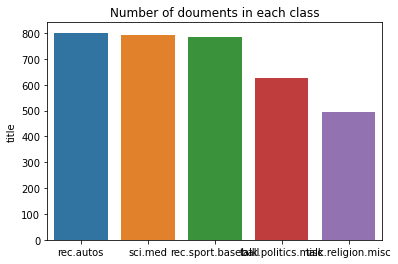

In [23]:
#Count the number of douments in each class
x=df_train['title'].value_counts()
print(x)
sns.barplot(x.index,x).set(title="Number of douments in each class")

In [24]:
# Find NaN values
df_test.isna().sum()

text      29
target     0
title      0
date       0
dtype: int64

In [25]:
# Drop NaN values
df_train = df_train.dropna()
df_test = df_test.dropna()
# Check for it
df_test.isna().sum()

text      0
target    0
title     0
date      0
dtype: int64

In [26]:
# Some word count examples
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==9]['word_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['word_count'].mean()) # Baseball posts

126.6788990825688
135.47783251231527


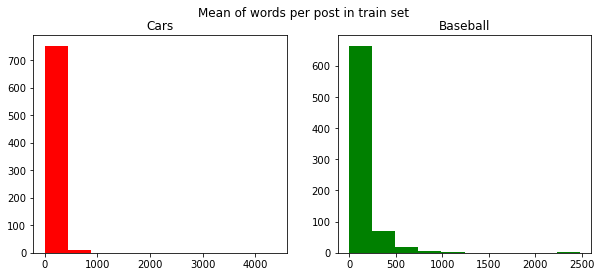

In [27]:
# Some Word-Count plots examples
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Mean of words per post in train set')
plt.show()

In [28]:
# Some character count examplesS
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['char_count'].mean()) # Baseball posts


732.1913499344691
795.2857142857143


## Text processing

In [29]:
# Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# Remove Stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# Lemmatize:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [30]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# Obtain clean text columns
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))


In [31]:
# Obtain final train and test vectors 
X_train, y_train = df_train["clean_text"], df_train["target"]
X_test, y_test = df_test["clean_text"], df_test["target"]


# Tokenize sentences to future applications
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

## Text vectorizers

In [32]:
#TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
#Obtain vectors via TF-IDF
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [33]:
# Doc2Vec vectorizer
train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [34]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [35]:
# Obtain vectors via doc2vec
y_train_w2v, x_train_w2v = vec_for_learning(model, train_docs)


## Train different models

In [36]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

lr_acc = accuracy_score(y_test, y_predict)
lr_f1 = f1_score(y_test, y_predict, average ='weighted')
lr_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {lr_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {lr_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {lr_f1} \n")

              precision    recall  f1-score   support

           7       0.83      0.93      0.88       179
           9       0.93      0.95      0.94       203
          13       0.92      0.92      0.92       190
          18       0.90      0.83      0.86       145
          19       0.90      0.81      0.85       130

    accuracy                           0.90       847
   macro avg       0.90      0.89      0.89       847
weighted avg       0.90      0.90      0.90       847

Confusion Matrix: [[166   2   7   1   3]
 [  7 193   2   0   1]
 [  7   3 175   4   1]
 [ 10   5   3 120   7]
 [ 10   4   3   8 105]]
Test Accuracy of Logistic Regression(tf-idf) is 0.8961038961038961 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.8868888728199884 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.8956615772057323 



In [37]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

nb_acc = accuracy_score(y_test, y_predict)
nb_f1 = f1_score(y_test, y_predict, average ='weighted')
nb_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {nb_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {nb_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {nb_f1} \n")

              precision    recall  f1-score   support

           7       0.89      0.92      0.90       179
           9       0.92      0.97      0.94       203
          13       0.82      0.94      0.87       190
          18       0.79      0.85      0.82       145
          19       0.96      0.57      0.71       130

    accuracy                           0.87       847
   macro avg       0.88      0.85      0.85       847
weighted avg       0.88      0.87      0.86       847

Confusion Matrix: [[164   3   8   3   1]
 [  1 196   6   0   0]
 [  5   2 178   4   1]
 [  4   4  13 123   1]
 [ 11   7  12  26  74]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8677685950413223 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8472134190521278 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.8626795636018855 



## Define toy set of users

In [38]:
# Associate targets with interests
interests = ["autos", "baseball", "medicine", "politics", "religion"]

def generate_users(n_user, interests= ["autos", "baseball", "medicine", "politics", "religion"]):
    users = {}
    for user in range(n_user):
        n_interest = random.randint(1, 3)
        user_interest = []
        i = random.sample(range(0,4), n_interest)
        user_interest.append([interests[e] for e in i])
            
        users[user] = user_interest
    return users

In [39]:
# Generate users
users = generate_users(10)
print(users)

{0: [['autos']], 1: [['autos']], 2: [['politics']], 3: [['politics']], 4: [['politics', 'baseball', 'medicine']], 5: [['autos']], 6: [['medicine', 'autos', 'politics']], 7: [['medicine', 'politics', 'autos']], 8: [['autos']], 9: [['baseball', 'autos', 'medicine']]}


In [44]:
# Predict the type of the query text using the best classifier
pred = nb_tfidf.predict(X_test_vectors_tfidf[1])
print(pred[0].split('.')[-1])


array([7], dtype=int64)

In [ ]:
# function that automatically assigns texts for users
def assigne_text(users, pred):
    if 'med' in pred:
        text = 'medicine'
    elif 'autos' in pred:
        text = 'autos'
    elif 'politics' in pred:
        text = 'politics'
    elif 'religion' in pred:
        text = 'religion'
    elif 'baseball':
        text = 'baseball'
    assigned = []
    for user, interest in users.items():
        if text in interest[0]:
            assigned.append(user)
            
    return assigned, text.upper()

In [ ]:
assigned, text_topic = assigne_text(users, pred[0])
for user in assigned:
    print("This text is assigned to user {}. It is a {} text.".format(user, assigned_text[1]))

This text is assigned to user 1. It is a medicine text.
This text is assigned to user 3. It is a medicine text.
This text is assigned to user 4. It is a medicine text.
This text is assigned to user 6. It is a medicine text.
